In [167]:
import sqlite3
import re
import pandas as pd
import numpy as np

In [166]:
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import gensim
# import logging
# logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
# logging.root.level = logging.INFO  # ipython sometimes messes up the logging setup; restore

## Clean up subject function

In [11]:
# conn = sqlite3.connect('../hillary-clinton-emails/database.sqlite')
# cur = conn.cursor()
# cur.execute('pragma table_info(Emails)')
# f_1 = 'Id'
# f_2 = 'MetadataTo'
# f_3 = 'MetadataFrom'
# f_4 = 'ExtractedSubject'
# f_5 = 'ExtractedDateSent'
# f_6 = 'ExtractedBodyText'
# f_7 = 'RawText'
# cur.execute('select {c1},{c2},{c3},{c4},{c5},{c6},{c7} from Emails'.\
#             format(c1=f_1,c2=f_2,c3=f_3,c4=f_4,c5=f_5,c6=f_6,c7=f_7))
# cur.fetchall()
# cur.fetchone()
# columns_less = ['id','to','from','sub','date','body','raw']
# columns = [str(tpl[1]) for tpl in columns]
def clean_subject(sub):
    email_type = None
    if re.match('^[Ff][Ww]',sub)!=None:
        email_type='fw'
        sub = re.sub('^[Ff][Ww].*:\s*(.+)',r'\1',sub)
    elif re.match('^[Rr][Ee]:',sub)!=None:
        email_type='re'
        sub = re.sub('^[Rr][Ee]:\s*(.+)',r'\1',sub)
    elif re.match('^[Ff][Vv][Vv]:',sub)!=None:
        email_type='fvv'
        sub = re.sub('^[Ff][Vv][Vv]:\s*(.+)',r'\1',sub)
    return email_type,sub

## Clean up date function

In [12]:
# txt = 'Thursday, September 30, 2010 9:04 PM'
# txt = 'Thu Sep 17 06:03:43 2009'
def clean_date_aux(ts):
    pat = re.compile('\'?(?P<weekday>\w+),?\s*(?P<month>\w+) (?P<date>\d+),?\s*(?P<year>\d+) (?P<time>.+) (?P<ampm>[A|P]M)')
    pat1 = re.compile('(?P<weekday>.+) (?P<month>.+) (?P<date>.+) (?P<time>.+) (?P<year>.+)')
    if ts=='':
        return np.NAN
    re_obj = None
    try:
        if pat.match(ts)!=None:
            re_obj = pat.match(ts)
        elif pat1.match(ts)!=None:
            re_obj = pat1.match(ts)
        else:
            raise
        # Process date
        month = re_obj.group('month')
        day = re_obj.group('date')
        year = re_obj.group('year')
        time = re_obj.group('time').replace('.',':')
        # Check for numeric value of day and year
        try:
            month = month[:3]
            day = int(day)
            year = int(year)
        except:
            raise
        # Check time string
        if ':' not in time and len(time)>2:
            time = time[:-2]+':'+time[-2:]
        try:
            time = time + ' ' + re_obj.group('ampm')
        except:
            pass
        ts_str = "{} {} {} {}".format(month,day,year,time)
        try:
            pd_ts = pd.to_datetime(ts_str)
            return pd_ts
        except:
            raise
    except:
        return np.NAN
    
def clean_date(raw_date):
    return clean_date_aux(raw_date)

## Tokenize function

In [13]:
def tokenize(text):
    text = text.replace("\n"," ")
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

In [86]:
# Fetch emails
conn = sqlite3.connect('../hillary-clinton-emails/database.sqlite')
sql = """select Id, SenderPersonId, ExtractedDateSent, ExtractedSubject
, ExtractedBodyText
from Emails
"""
emails = pd.read_sql_query(sql,conn)

In [88]:
# Clean up subject
temp = emails.ExtractedSubject.apply(clean_subject)
emails['ExtractedSubject'] = [tpl[1] for tpl in temp]
emails['Email_type'] = email_type = [tpl[0] for tpl in temp]
emails[['Id','SenderPersonId','ExtractedSubject','Email_type']].head(5)

,Id,SenderPersonId,ExtractedSubject,Email_type
0,1,87,Wow,fw
1,2,,,None
2,3,32,Chris Stevens,re
3,4,32,Cairo Condemnation - Final,fvv
4,5,80,,None


In [16]:
# Clean up date
emails['Date']=emails.ExtractedDateSent.apply(clean_date)
emails.head(10)
# emails = emails.dropna(how='any')
emails.index = emails.Date
emails.sort_index(inplace=True)
mindate,maxdate = emails.index.min(),emails.index.max()
print("Date Range from {} to {}".format(mindate.date(),maxdate.date()))
emails[:'2011-01'].Id.count()

Date Range from 2009-03-13 to 2012-12-24


6312

## Find mails with moderate email body size

In [90]:
# Sort emails based on body size
emails1 = emails[['Id','ExtractedSubject','ExtractedBodyText']]
# Sort
emails1['BodyLength'] = emails1.ExtractedBodyText.apply(lambda text:len(text))
emails1 = emails1[(emails1['BodyLength']>50) & (emails1['BodyLength']<1000)]
emails_sorted = emails1.sort_values('BodyLength',ascending=False)
email_text = [txt for txt in emails_sorted.ExtractedBodyText]
# load LDA model
# lda_model = gensim.models.LdaModel.load('model.lda')
# Create BoW
email_id = np.array([i for i in emails_sorted['Id']])
email_tokens = emails_sorted.ExtractedBodyText.apply(tokenize)
email_tokens_stream = [tokens for tokens in email_tokens]
vocab = gensim.corpora.Dictionary(email_tokens_stream)
    # vocab.filter_extremes(no_below=20,no_above=0.8)
email_bow = email_tokens.apply(lambda tokens:vocab.doc2bow(tokens))
email_bow = [bow for bow in email_bow]
topics = []
for i in range(200):
    dist = lda_model.get_document_topics(email_bow[i])
    best_topics = sorted(dist,key=lambda item:item[1],reverse=True)
    topics.append(best_topics[1][0]) # second best topic
print(email_id[:200])
print(topics)
topic_x = [email_id[i] for i,topic in enumerate(topics) if topic==7]
print(topic_x)
with open('out.txt','w') as f_out:
    for idx in topic_x:
        pos = np.where(email_id == idx)[0][0]
        f_out.write('--------------------------------Email-Id: {}-----------------------------'.format(str(idx)))
        f_out.write('\n')
        f_out.write(email_text[pos])
        f_out.write('\n')

/home/debojyoti/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[5009 6172 5204 4960 2880 5454 2794 4227 2722 6163  212 1859 2443 4861 6761
 1037   61 5411 5553 1571 2365 3381 3755 4501 5042 7847 5449 5850 1866 4160
 5346 5240 4871  811 6218 7257 7513 3512 7170 3655 6270 5303 5482 6579 4880
   98 4826 6900 3412 1676 5476 2766 4530 4507 5928 5754 3775 7925 5792 6737
   72 4816 5864 4660 4271 5116 1648 1431 6475 5972 1583 1778 4933 5597 6512
 5136 3908 5980 6196 3474 5305 3963 4922 5987 7677 7610 2284 4432 6032 5733
  345 2967   56 5139 2731 3421 5920 6818 7851 1388 2672 2267 7899 4407 3242
 4894 1513 6185 6738 4445    6   16 3449 2492 2479 5424 5180 6679 3717 1549
 1582 6747 7583 4286 2507 2649 2529 5149  217 1691 4498 5026 5659 5570 5700
 6562  943 3382 6007 1641 4667 6748 2049 7253 2637 2099 4878 6735 6734 4000
 1244 6241 1252 3369 6529 3525 5442 3159 1413 6557 6423 4415   82 5488 2522
 5578 6552 2957 7892 2518 3555 6468 3478 4906 4618  131   53 6174 4626 4305
 4655 6686 3310  940 5446 5439 5456 7912 5102 6547 2428 5973  123  809 2275
 2258 6725 2

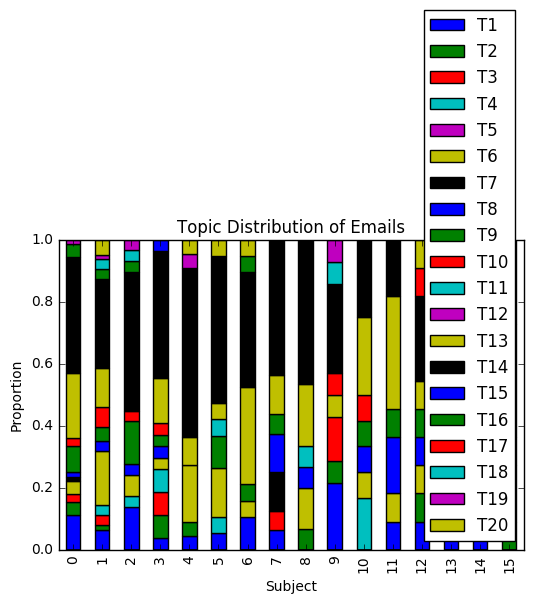

In [194]:
sub_count = emails1.groupby('ExtractedSubject').Id.count()
sub_count = sub_count.sort_values(ascending=False)
sub_count = sub_count[sub_count>10]
subs = sub_count.keys().values
counts = sub_count.values
topic_dist = []
# emails1[emails1['ExtractedSubject']=='more on Libya']
for sub in subs:
    if sub=='':
        continue
    emails_tmp = emails1[emails1['ExtractedSubject']==sub]
    ids = list(emails_tmp['Id'])
    topics = np.zeros(20)
    for i in ids:
        pos = np.where(email_id==i)[0][0]
        dist = lda_model.get_document_topics(email_bow[pos])
        best_topics = sorted(dist,key=lambda item:item[1],reverse=True)
#         print(best_topics)
        topic_idx = best_topics[0][0] # second best topic
        topics[topic_idx] += 1
    topics /= sum(topics)
    topic_dist.append(topics)
topic_dist = np.array(topic_dist)
column_names = ['T'+str(i) for i in range(1,21)]
df = pd.DataFrame(topic_dist , columns=column_names)
ax = df.plot.bar(stacked=True,legend=True, title='Topic Distribution of Emails')
ax.set_xlabel('Subject')
ax.set_ylabel('Proportion')

## Clean-up sender receiver

In [51]:
# Fetch data in pandas dataframe
conn = sqlite3.connect('../hillary-clinton-emails/database.sqlite')
# sql = "select * from Emails"
# emails = pd.read_sql_query(sql,conn)
# columns = ['Id','SenderPersonId','MetadataFrom','MetadataTo','ExtractedDateSent','ExtractedSubject','ExtractedBodyText']
# emails[columns].head(5)
# emails[emails['SenderPersonId']==80][columns].head(5)
# x = emails.groupby('SenderPersonId').size()
# print 'No of mails sent by HC =',x[80]

# Assign receiver Id
sql = """select e.Id, p.Name Sender, 
e.SenderPersonId Sender_Id, e.MetadataTo Receiver, a.PersonId Receiver_Id, e.ExtractedDateSent
from Emails e 
inner join Persons p on e.SenderPersonId=p.Id 
left outer join Aliases a on lower(e.MetadataTo)=a.Alias
"""
emails1 = pd.read_sql_query(sql,conn)
# emails_noNA = emails.dropna(how='any')
# emails.head(20)
idx_NaN = [i for i,val in enumerate(emails1['Receiver_Id']) if np.isnan(val)]


# Create dictionary personId:name
sql = "select * from Persons"
persons = pd.read_sql_query(sql,conn)
name2id = {}
id2name = {}
for entry in persons.itertuples():
    name2id[entry[2]]=entry[1]
    id2name[entry[1]]=entry[2]
    
# Fill up missing Receiver_Id fields
receiver_dict = {}
pattern = re.compile('^(\w+),\sp*(\w+)')
for idx in idx_NaN:
    name = emails1['Receiver'][idx]
    pat_obj = pattern.match(name)
    if pat_obj!=None:
        person_name = pat_obj.group(2)+' '+pat_obj.group(1)
        try:
            person_id = name2id[person_name]
            emails1['Receiver_Id'][idx]=person_id
        except:
            pass
temp = emails1.shape[0]
emails1 = emails1.dropna(how='any')
print('Discarded emails: ',temp-emails1.shape[0])

/home/debojyoti/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Discarded emails:  174


## Rank contacts on interraction frequency

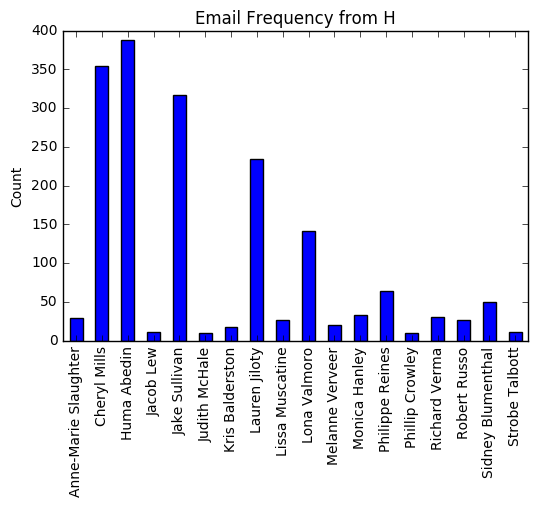

In [52]:
emails_from_H = emails1[emails1['Sender_Id']==80]
x = emails_from_H.groupby('Receiver_Id')['Id'].count()
person_ids = np.array(x.index.values)
counts = np.array([i for i in x])
# ind_sorted = np.array(np.argsort(counts)[::-1][:len(counts)])
# counts = counts[ind_sorted]
# person_ids = person_ids[ind_sorted]
# for i in person_ids[:10]:
#     print id2name[i]
person_names = [id2name[i] for i in person_ids]
%matplotlib inline
df = pd.DataFrame(np.array(counts),person_names)
df = df[df[0]>9]
ax = df.plot(kind='bar',legend=False,title='Email Frequency from H')
ax.set_ylabel('Count')

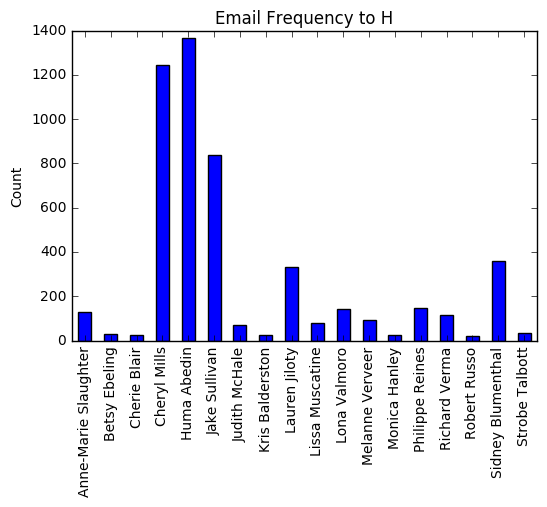

In [53]:
emails_from_H = emails1[emails1['Receiver_Id']==80]
x = emails_from_H.groupby('Sender_Id')['Id'].count()
person_ids = np.array(x.index.values)
counts = np.array([i for i in x])
# ind_sorted = np.array(np.argsort(counts)[::-1][:len(counts)])
# counts = counts[ind_sorted]
# person_ids = person_ids[ind_sorted]
# for i in person_ids[:10]:
#     print id2name[i]
person_names = [id2name[i] for i in person_ids]
%matplotlib inline
df = pd.DataFrame(np.array(counts),person_names)
df = df[df[0]>20]
ax = df.plot(kind='bar',legend=False,title='Email Frequency to H')
ax.set_ylabel('Count')

## Process email body: Topic modelling

In [79]:
class HillaryEmails(object):
    def __init__(self,doc_vectors):
        self.doc_vectors = doc_vectors
    def __iter__(self):
        for vector in self.doc_vectors:
            yield vector

In [80]:
def do_BoW(tokens):
    return vocab.doc2bow(tokens)
def get_maxwords(vector):
    minimum = int(len(vector)*0.2)
    minimum = min(10,minimum)
    global vocab
    temp = sorted(vector,key=lambda x:x[1],reverse=True)
    topic = [vocab[it[0]] for it in temp[:minimum]]
    return topic
conn = sqlite3.connect('../hillary-clinton-emails/database.sqlite')
sql = """select e.Id, p.Name Sender, 
e.SenderPersonId Sender_Id, e.ExtractedDateSent, e.ExtractedBodyText
from Emails e 
inner join Persons p on e.SenderPersonId=p.Id
"""
emails = pd.read_sql_query(sql,conn)
emails['ExtractedDateSent']=emails.ExtractedDateSent.apply(clean_date)
# Step 1: Mails from Hillary
# emails = emails[emails['Sender_Id']==80]
# Step 2: Tokenize email body
email_tokens = emails.ExtractedBodyText.apply(tokenize)
doc_stream = [tokens for tokens in email_tokens]
print(len(doc_stream))
# Step 3: Build Vocabulary
%time vocab = gensim.corpora.Dictionary(doc_stream)
    # vocab.filter_extremes(no_below=20,no_above=0.8)
# Step 4: Run BoW on docs
vectors_doc = email_tokens.apply(do_BoW)
maxwords = vectors_doc.apply(get_maxwords)
#Step 5: save doc vectors in mm file
hillary_emails_corpus = HillaryEmails(vectors_doc)
%time gensim.corpora.MmCorpus.serialize('emails_bow.mm',hillary_emails_corpus)

7788
CPU times: user 312 ms, sys: 0 ns, total: 312 ms
Wall time: 310 ms
CPU times: user 260 ms, sys: 0 ns, total: 260 ms
Wall time: 262 ms


In [81]:
# hillary_mm_corpus = gensim.corpora.MmCorpus('emails_bow.mm')
# clipped_corpus = gensim.utils.ClippedCorpus(hillary_emails_corpus,1600)
tfidf = gensim.models.TfidfModel(vectors_doc)
#print(tfidf)
corpus_tfidf = tfidf[vectors_doc]
%time lda_model = gensim.models.LdaModel(corpus_tfidf, num_topics=20, id2word=vocab, passes=4)
lda_model.save('model.lda')

CPU times: user 1min 25s, sys: 1.5 s, total: 1min 27s
Wall time: 33.3 s


In [18]:
lda_model.get_document_topics(vectors_doc[10])
for topic in range(lda_model.num_topics):
    print(topic,lda_model.show_topic(topic,topn=10))
lda_model.get_topic_terms(10)
# lda_model.get_term_topics(vocab.token2id['state'])

(0, [(u'joanne', 0.0059464459198925543), (u'reach', 0.0049210436389491574), (u'grid', 0.0048683136978191419), (u'laszczych', 0.004224262686665722), (u'congrats', 0.0032811049561077017), (u'droid', 0.0026838465319289329), (u'pj', 0.00262806552701465), (u'toivnf', 0.0025905704750807), (u'sheets', 0.0023894218173086206), (u'recommend', 0.0022832509496163102)])
(1, [(u'pm', 0.017235943759684343), (u'office', 0.014789445861803327), (u'secretary', 0.010793266224918807), (u'meeting', 0.0085487959618695628), (u'sounds', 0.0078753151298399677), (u'room', 0.0074067285298376638), (u'arrive', 0.0072413636698547366), (u'qddr', 0.0063004656993456169), (u'en', 0.0061451566744741559), (u'depart', 0.0061066589872638402)])
(2, [(u'hrod', 0.01226637602773345), (u'clintonemail', 0.011964042230323688), (u'com', 0.010413296844318022), (u'january', 0.0094539140584589901), (u'gov', 0.0085966715412794138), (u'sullivanjj', 0.0084702368873337645), (u'pm', 0.0077503926317449984), (u'sullivan', 0.00698126141193225

[(343, 0.0088666803647233783),
 (931, 0.0055209262341980999),
 (277, 0.005450162143061309),
 (3185, 0.0047678230537086998),
 (5429, 0.0040854451119411326),
 (1335, 0.0039180954945618896),
 (3921, 0.0038701993511902509),
 (841, 0.0038425523787720779),
 (4930, 0.0037779330244748963),
 (4761, 0.0034969364204439015)]

In [190]:
# Visualization
# see https://pyldavis.readthedocs.io/en/latest/modules/API.html#pyLDAvis.prepare
%matplotlib inline

import pyLDAvis

n_doc = len(vectors_doc)
n_topic = lda_model.num_topics
n_vocab = len(vocab.keys())

# step 0
topic_term_dists = np.zeros([n_topic,n_vocab])
for topic_num in range(n_topic):
    word_dist = lda_model.get_topic_terms(topic_num,topn=n_vocab)
    words = [i for i,_ in word_dist]
    prob = [i for _,i in word_dist]
    topic_term_dists[topic_num][words] = prob

# step 1
doc_topic_dists = np.zeros([n_doc,n_topic]) # n_doc x n_topic
for doc_num in range(n_doc):
    topic_dist = lda_model.get_document_topics(vectors_doc[doc_num],minimum_probability=0)
    topics = [i for i,_ in topic_dist]
    probs = [i for _,i in topic_dist]
    doc_topic_dists[doc_num][topics] = probs

# step 2
doc_lengths = (np.zeros(n_doc)).astype(int)
for doc_num in range(n_doc):
    l = np.sum([i for _,i in vectors_doc[doc_num]])
    doc_lengths[doc_num] = int(l)
    
# step 3
vocab_list = np.array(vocab.values())

# step 4
term_frequency = np.zeros(n_vocab)
for doc_num in range(n_doc):
    words = [i for i,_ in vectors_doc[doc_num]]
    freq = [i for _,i in vectors_doc[doc_num]]
    term_frequency[words] += freq

movies_vis_data = pyLDAvis.prepare(topic_term_dists, doc_topic_dists, doc_lengths, vocab_list, term_frequency)
pyLDAvis.display(movies_vis_data)

ImportError: No module named 'pyLDAvis'

In [ ]:
hillary_mm_corpus = gensim.corpora.MmCorpus('emails_bow.mm')
%time tfidf_model = gensim.models.TfidfModel(hillary_mm_corpus, id2word=vocab)
%time lsi_model = gensim.models.LsiModel(tfidf_model[hillary_mm_corpus], id2word=vocab, num_topics=200)

## Running R from python

In [ ]:
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector
base = importr('base')
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)

In [ ]:
packnames = ['ggplot2']
names_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
if len(names_to_install)>0:
    utils.install_packages(StrVector(names_to_install))

## Sentiment Analysis on countries

In [176]:
import nltk
from nltk.tokenize import sent_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

In [177]:
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
n_instances = 100
subj_docs = [(sent,'subj') for sent in subjectivity.sents(categories='subj')[:n_instances]]
obj_docs = [(sent,'obj') for sent in subjectivity.sents(categories='obj')[:n_instances]]
# subj_docs[10],obj_docs[1]
train_docs = subj_docs[:80]+obj_docs[:80]
test_docs = subj_docs[80:100]+obj_docs[80:100]
senti_analyser = SentimentAnalyzer()

In [178]:
sent = "He is a murderer"
sentiAnalyser = SentimentIntensityAnalyzer()
sentiAnalyser.polarity_scores(sent)

{'compound': -0.6808, 'neg': 0.697, 'neu': 0.303, 'pos': 0.0}

## Find sentiment of emails

In [179]:
def getSentiment(text):
    pos = 0
    neg = 0
    neu = 0
    if text=='':
        return 0,pos,neg
    global sentiAnalyser
    text = text.replace('\n',' ')
    sentences = sent_tokenize(text)
    sentences = [sent for sent in sentences if len(sent.split())>2]
    for sent in sentences:
        senti = sentiAnalyser.polarity_scores(sent)
        if senti['neu']>=0.9:
            neu += 1
        else:
            pos += senti['pos']
            neg += senti['neg']
    count = len(sentences)-neu
    if count == 0:
        return len(sentences),pos,neg
    return len(sentences),pos/count,neg/count
conn = sqlite3.connect('../hillary-clinton-emails/database.sqlite')
sql = """select e.Id, p.Name Sender, 
e.SenderPersonId Sender_Id, e.ExtractedDateSent, e.ExtractedBodyText
from Emails e 
inner join Persons p on e.SenderPersonId=p.Id
"""
emails = pd.read_sql_query(sql,conn)
emails['ExtractedDateSent']=emails.ExtractedDateSent.apply(clean_date)
# Step 1: Mails from Hillary
emails = emails[emails['Sender_Id']==80]
# emails = emails.head(5)
# emails.ExtractedBodyText.apply(getSentiment)
print('Total Email count by Hillary: ',emails.Id.count())
sentiAnalyser = SentimentIntensityAnalyzer()
%time sentiments = emails.ExtractedBodyText.apply(getSentiment)
senti_map = zip(emails.Id.values,sentiments.values)
senti_map = sorted(senti_map,key = lambda item:item[1][2],reverse=True)
print(senti_map[:5])

('Total Email count by Hillary: ', 1993)
CPU times: user 1.28 s, sys: 64 ms, total: 1.34 s
Wall time: 1.24 s
[(552, (7, 0.0, 0.772)), (2240, (1, 0.0, 0.7)), (585, (3, 0.0, 0.531)), (1022, (2, 0.0, 0.508)), (2308, (1, 0.0, 0.483))]


In [33]:
txt = 'my name is khan my name. hhhbg name'
pat = '\\b'+'name'
z = list(re.finditer(pat,txt))
len(z)

3

## Find occurance of country name in mails

In [19]:
import pycountry

In [169]:
def get_count(text):
    global country_counter
    global countries_new_name
    for indx,country in enumerate(pycountry.countries):
        name = country.name
        if name in countries_new_name.keys():
            name = countries_new_name[name]
        name = '\\b'+name # Ensuring substring start with country name. eg.Indian, Syrian, India
        all_matches = re.finditer(name,text,re.IGNORECASE)
        n_occurrences = len(list(all_matches))
        country_counter[indx] += n_occurrences
        abbr_to_ignore = ["RE", "FM", "TV", "AL", "AQ", "LA", "BEN"]
        if country.alpha2 not in abbr_to_ignore:
            name = '\\b'+country.alpha2+'\\b'
            all_matches = re.finditer(name,text)
            n_occurrences = len(list(all_matches))
            country_counter[indx] += n_occurrences
        if country.alpha3 not in abbr_to_ignore:
            name = '\\b'+country.alpha3+'\\b'
            all_matches = re.finditer(name,text)
            n_occurrences = len(list(all_matches))
            country_counter[indx] += n_occurrences
country_counter = [0 for country in pycountry.countries]
country_names = [country.name for country in pycountry.countries]
countries_new_name = {'Syrian Arab Republic':'Syria','Russian Federation':'Russia','Iran, Islamic Republic of':\
                      'Iran','Korea, Democratic People\'s Republic of':'Korea','Palestine, State of':'Palestine',\
                      'Venezuela, Bolivarian Republic of':'Venezuela'}
%time emails.ExtractedBodyText.apply(get_count)
# let's study count for some countries
country2ind = {}
for indx,country in enumerate(pycountry.countries):
    country2ind[country.name]=indx
country_name_count = zip(country_names,country_counter)
country_name_count = sorted(country_name_count,key = lambda item:item[1],reverse=True)
for i,name in enumerate(country_names):
    if name in countries_new_name.keys():
        country_names[i]=countries_new_name[name]

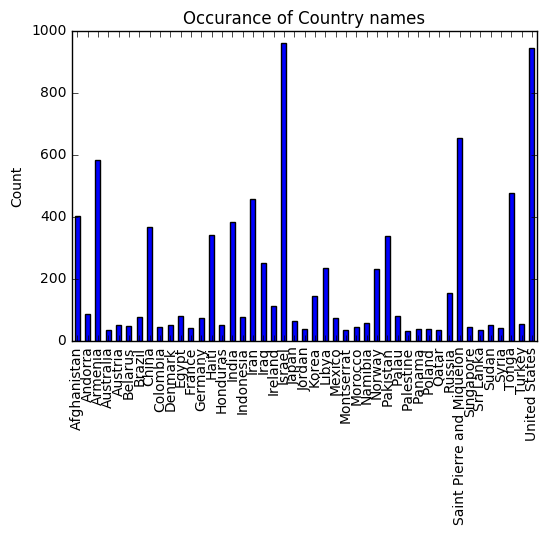

In [170]:
%matplotlib inline
df = pd.DataFrame(np.array(country_counter),country_names)
df = df[df[0]>30]
ax = df.plot(kind='bar',legend=False,title='Occurance of Country names')
ax.set_ylabel('Count')

## Sentence-wise average sentiment of top mentioned countries

In [61]:
def senti_cumulative(text,name,abr1,abr2,country_indx):
    if text=='':
        return
    regex = r'.*\s{}|.*\s{}\s|.*\s{}\s'.format(name,abr1,abr2)
    if abr1 is None and abr2 is None:
        regex = r'.*\s{}'.format(name)
    elif abr1 is None:
        regex = r'.*\s{}|.*\s{}\s'.format(name,abr2)
    elif abr2 is None:
        regex = r'.*\s{}|.*\s{}\s'.format(name,abr1)
    re_obj = re.compile(regex)
    text = text.replace('\n',' ')
    if re_obj.match(text)==None:
        return
    # sentiment for sentences with country name
    global sentiAnalyser
    global positives
    global negatives
    global sent_count
    sentences = sent_tokenize(text)
    sentences = [sent for sent in sentences if len(sent.split())>2]
    for sent in sentences:
        if re_obj.match(sent)==None:
            continue
        senti = sentiAnalyser.polarity_scores(sent)
        positives[country_indx] += senti['pos']
        negatives[country_indx] += senti['neg']
        sent_count[country_indx] += 1        
        
def get_country_sentiment_sentencewise(country,indx):
    global countries_new_name
    global emails
    name = country.name
    abr1 = country.alpha2
    abr2 = country.alpha3
    abbr_to_ignore = ["RE", "FM", "TV", "AL", "AQ", "LA", "BEN"]
    if name in countries_new_name:
        name = countries_new_name[name]
    if abr1 in abbr_to_ignore:
        abr1 = None
    if abr2 in abbr_to_ignore:
        abr2 = None
    emails.ExtractedBodyText.apply(senti_cumulative,args=(name,abr1,abr2,indx))
    
country_obj_list = [it for it in pycountry.countries]
positives = (np.zeros_like(country_counter)).astype(float)
negatives = (np.zeros_like(country_counter)).astype(float)
sent_count = np.zeros_like(country_counter)
for indx,count in enumerate(country_counter):
    if count>50:
        get_country_sentiment_sentencewise(country_obj_list[indx],indx)
for i in range(len(sent_count)):
    if sent_count[i]>0:
        positives[i] /= sent_count[i]
        negatives[i] /= sent_count[i]

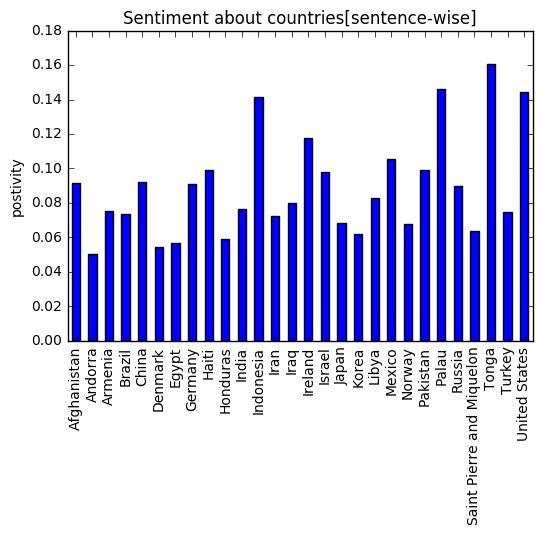

In [171]:
df = pd.DataFrame(positives,country_names)
df = df[df[0]>0]
ax = df.plot(kind='bar',legend=False,title='Sentiment about countries[sentence-wise]')
ax.set_ylabel('postivity')

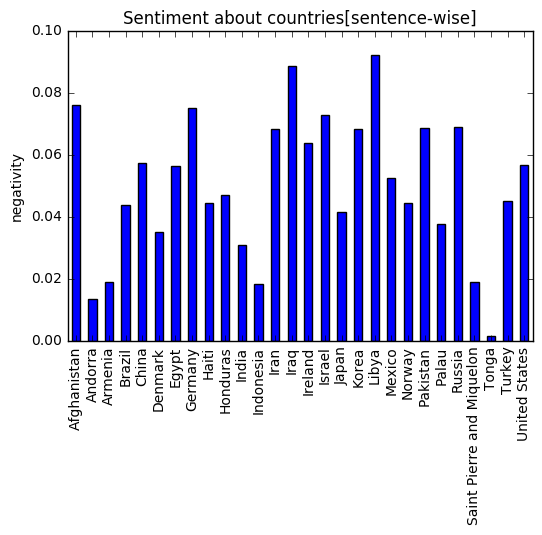

In [172]:
df = pd.DataFrame(negatives,country_names)
df = df[df[0]>0]
ax = df.plot(kind='bar',legend=False,title='Sentiment about countries[sentence-wise]')
ax.set_ylabel('negativity')

## Correlation between country vs average sentiment

In [180]:
def get_occurence_ct(text,country):
    name = country.name
    counter = 0
    global countries_new_name
    if name in countries_new_name.keys():
        name = countries_new_name[name]
    name = '\\b'+name # Ensuring substring start with country name. eg.Indian, Syrian, India
    all_matches = re.finditer(name,text,re.IGNORECASE)
    n_occurrences = len(list(all_matches))
    counter += n_occurrences
    abbr_to_ignore = ["RE", "FM", "TV", "AL", "AQ", "LA", "BEN"]
    if country.alpha2 not in abbr_to_ignore:
        name = '\\b'+country.alpha2+'\\b'
        all_matches = re.finditer(name,text)
        n_occurrences = len(list(all_matches))
        counter += n_occurrences
    if country.alpha3 not in abbr_to_ignore:
        name = '\\b'+country.alpha3+'\\b'
        all_matches = re.finditer(name,text)
        n_occurrences = len(list(all_matches))
        counter += n_occurrences
    return counter
def get_country_sentiment(country):
    global sentiments
    global emails
    res_pos,res_neg = 0,0
    counts = emails.ExtractedBodyText.apply(get_occurence_ct,args=(country,))
    sentiments_pos = [tpl[1] for tpl in sentiments.values]
    sentiments_neg = [tpl[2] for tpl in sentiments.values]
    if sum(counts.values)>0:
        res_pos = sum([ct*pos for ct,pos in zip(counts.values,sentiments_pos)])/sum(counts.values)
        res_neg = sum([ct*neg for ct,neg in zip(counts.values,sentiments_neg)])/sum(counts.values)
    return res_pos,res_neg
countries = pd.Series([country for country in pycountry.countries])
senti = countries.apply(get_country_sentiment)

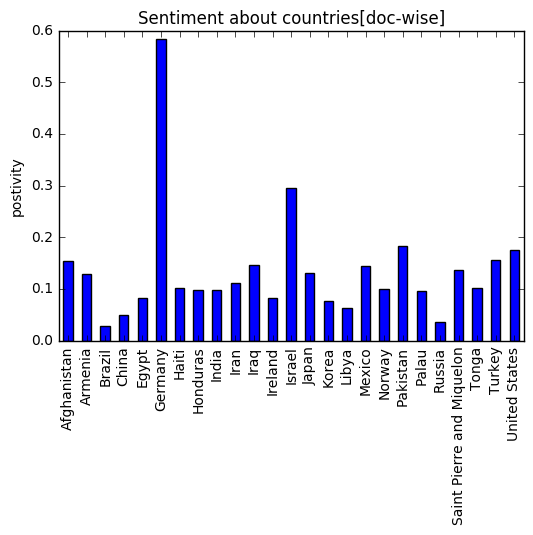

In [181]:
senti_pos = np.array([i[0] for i in senti])
for indx,count in enumerate(country_counter):
    if count<=50:
        senti_pos[indx]=0
df = pd.DataFrame(senti_pos,country_names)
df = df[df[0]>0]
ax = df.plot(kind='bar',legend=False,title='Sentiment about countries[doc-wise]')
ax.set_ylabel('postivity')

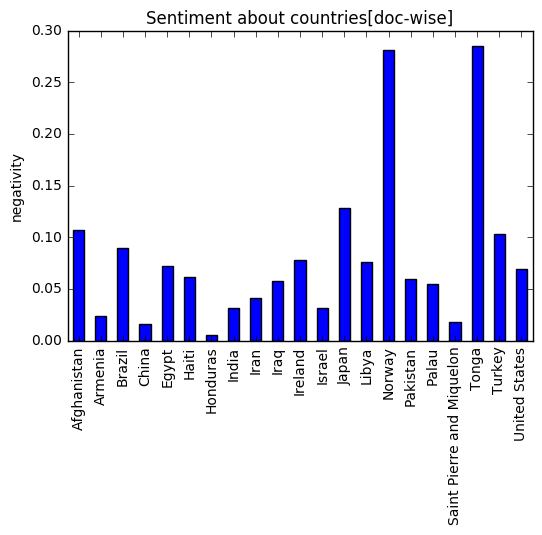

In [182]:
senti_neg = np.array([i[1] for i in senti])
for indx,count in enumerate(country_counter):
    if count<=50:
        senti_neg[indx]=0
df = pd.DataFrame(senti_neg,country_names)
df = df[df[0]>0]
ax = df.plot(kind='bar',legend=False,title='Sentiment about countries[doc-wise]')
ax.set_ylabel('negativity')